## 1. Libraries and settings

In [3]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
import os


## 2. Load data

In [3]:
processed_absa_price_diff = pd.read_csv(os.path.join('processed','processed_absa_price_diff.csv'),delimiter=',',index_col=0)
processed_day_level_absa = pd.read_csv(os.path.join('processed','processed_day_level_absa.csv'),delimiter=',',index_col=0)
processed_day_level_sa_roberta = pd.read_csv(os.path.join('processed','processed_day_level_sa_roberta.csv'),delimiter=',',index_col=0)
processed_day_level_sa_bert = pd.read_csv(os.path.join('processed','processed_day_level_sa_bert.csv'),delimiter=',',index_col=0)
processed_sa_bert_price_diff = pd.read_csv(os.path.join('processed','processed_sa_bert_price_diff.csv'),delimiter=',', index_col=0)
processed_sa_roberta_price_diff = pd.read_csv(os.path.join('processed','processed_sa_roberta_price_diff.csv'),delimiter=',',index_col=0)

In [1]:
# Select relevant features
features = ['usability_positive', 'design features_negative', 'general_neutral', 'price_positive', 
            'quality_positive', 'operation performance_negative', 'operation performance_positive', 
            'general_negative', 'design features_positive', 'general_positive', 'quality_negative']

## 3. Build the structure of model

In [26]:
# Build model
#####################
input_dim = 2
hidden_dim = 8
num_layers = 2
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        x = x.view(len(x), 1, -1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
LSTM_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(LSTM_model.parameters(), lr=0.001)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Load data
df1 = pd.read_csv(os.path.join('processed','processed_day_level_absa.csv'))
df2 = pd.read_csv(os.path.join('processed','processed_absa_price_diff.csv'))
df = pd.concat([df1, df2],axis=1)
df.head()
print(len(df))

103


In [121]:
num_epochs = {"0.001":25, "0.002":25, "0.01":30}
# Define a range of K values
lr_values = [0.001, 0.002, 0.01]
k_values = [10]
# Define a list of models to train
models = []
for i in range(len(features)):
    models.append(features[:i+1])

# Define a dictionary to store the accuracy values for each model and K value
mse_dict = {str(model): {k: [] for k in k_values} for model in models}

# Define a dictionary to store the confusion matrix for each model and K value
confusion_dict = {str(model): {k: [] for k in k_values} for model in models}
best_mse = 100
# Loop through the models and K values and perform K-fold cross-validation
for model in models:
    X = df[model].values
    y = df['to_predict'].values
    for lr in lr_values:
        tmp = []
        best_mse = [100 for _ in range(10)]
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            X_train = torch.from_numpy(X_train).type(torch.Tensor)
            X_test = torch.from_numpy(X_test).type(torch.Tensor)
            y_train = torch.from_numpy(y_train).type(torch.Tensor)
            y_test = torch.from_numpy(y_test).type(torch.Tensor)
            # Define and fit the logistic regression model
            for t in range(num_epochs[str(lr)]):
                # Forward pass
                LSTM_model = LSTM(input_dim=len(X[0]), hidden_dim=max(16, 2*len(X[0])), output_dim=output_dim, num_layers=num_layers)
                loss_fn = torch.nn.MSELoss()
                optimiser = torch.optim.Adam(LSTM_model.parameters(), lr=lr)
                y_train_pred = LSTM_model(X_train)

                loss = loss_fn(y_train_pred, y_train)
                if t % 20 == 0 and t !=0:
                    print("Epoch ", t, "MSE: ", loss.item())
                # Zero out gradient, else they will accumulate between epochs
                optimiser.zero_grad()
                # Backward pass
                loss.backward()
                # Update parameters
                optimiser.step()

            # calculate the accuracy and confusion matrix
            y_pred = LSTM_model(X_test)
            mse = mean_squared_error(y_test.flatten().detach(), y_pred.flatten().detach())
            tmp.append(mse)
        if np.mean(tmp) < np.mean(best_mse): 
            best_mse=tmp
            print(lr, num_epochs[str(lr)])
            # Store the accuracy and confusion matrix in the dictionaries
        mse_dict[str(model)][k] = best_mse
print(mse_dict)

E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.09374203532934189
Epoch  20 MSE:  0.10754569619894028
Epoch  20 MSE:  0.10372713953256607
Epoch  20 MSE:  0.1265449821949005


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.09385568648576736
Epoch  20 MSE:  0.10654711723327637
Epoch  20 MSE:  0.07964984327554703
Epoch  20 MSE:  0.08206120878458023


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07468855381011963
Epoch  20 MSE:  0.08609604090452194
0.001 25
Epoch  20 MSE:  0.12452942878007889
Epoch  20 MSE:  0.05716702342033386


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.11999364197254181
Epoch  20 MSE:  0.08545205742120743
Epoch  20 MSE:  0.0687175914645195


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07534745335578918
Epoch  20 MSE:  0.11199606955051422
Epoch  20 MSE:  0.12268413603305817
Epoch  20 MSE:  0.0819554328918457
Epoch  20 MSE:  0.13054907321929932
0.002 25


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08273560553789139
Epoch  20 MSE:  0.05697936937212944
Epoch  20 MSE:  0.08121398091316223


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.16737520694732666
Epoch  20 MSE:  0.07054056227207184
Epoch  20 MSE:  0.13554523885250092


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.10819242894649506
Epoch  20 MSE:  0.16438817977905273
Epoch  20 MSE:  0.10479854047298431
Epoch  20 MSE:  

E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

0.08316925913095474
0.01 30
Epoch  20 MSE:  0.07628259807825089
Epoch  20 MSE:  0.07259342074394226


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08606932312250137
Epoch  20 MSE:  0.08015083521604538
Epoch  20 MSE:  0.12173020839691162
Epoch  20 MSE:  0.08419797569513321


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07557473331689835
Epoch  20 MSE:  0.10292328149080276
Epoch  20 MSE:  0.07815615832805634


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07994642853736877
0.001 25
Epoch  20 MSE:  0.08898279070854187
Epoch  20 MSE:  0.06648348271846771
Epoch  20 MSE:  0.08878020942211151


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08070417493581772
Epoch  20 MSE:  0.07614196091890335
Epoch  20 MSE:  0.0766037181019783
Epoch  20 MSE:  0.15946246683597565
Epoch  20 MSE:  0.1314433515071869
Epoch  20 MSE:  0.14651377499103546
Epoch  20 MSE:  0.09372975677251816
0.002 25


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.0863235741853714
Epoch  20 MSE:  0.06025581806898117
Epoch  20 MSE:  0.08490346372127533
Epoch  20 MSE:  0.0864972397685051


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.09055665880441666
Epoch  20 MSE:  0.09742704033851624
Epoch  20 MSE:  0.07904884964227676


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.09091901779174805
Epoch  20 MSE:  0.07470282167196274
Epoch  20 MSE:  0.08859506994485855
0.01 30


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08449418842792511
Epoch  20 MSE:  0.06972532719373703
Epoch  20 MSE:  0.08232355117797852
Epoch  20 MSE:  0.082645945250988


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07329428195953369
Epoch  20 MSE:  0.07520042359828949
Epoch  20 MSE:  0.07724674046039581
Epoch  20 MSE:  0.08735156059265137


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.14950308203697205
Epoch  20 MSE:  0.08387437462806702
0.001 25
Epoch  20 MSE:  0.07880766689777374
Epoch  20 MSE:  0.05726135894656181
Epoch  20 MSE:  0.07850877940654755
Epoch  20 MSE:  0.10827585309743881
Epoch  20 MSE:  0.11815313994884491


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08388614654541016
Epoch  20 MSE:  0.08196313679218292
Epoch  20 MSE:  0.13922731578350067
Epoch  20 MSE:  0.1706809550523758


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07814391702413559
0.002 25
Epoch  20 MSE:  0.10359283536672592
Epoch  20 MSE:  0.08664385229349136


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08388528227806091
Epoch  20 MSE:  0.08293358981609344
Epoch  20 MSE:  0.08885985612869263


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.11900214105844498
Epoch  20 MSE:  0.13901716470718384
Epoch  20 MSE:  0.07570023089647293
Epoch  20 MSE:  0.12278761714696884
Epoch  20 MSE:  0.13596345484256744
0.01 30
Epoch  20 MSE:  0.07616943120956421


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.06742400676012039
Epoch  20 MSE:  0.13745246827602386
Epoch  20 MSE:  0.09747590124607086


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08006929606199265
Epoch  20 MSE:  0.10557080060243607
Epoch  20 MSE:  0.08799179643392563


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.11019625514745712
Epoch  20 MSE:  0.09062332659959793
Epoch  20 MSE:  0.07637413591146469
0.001 25


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.12458805739879608
Epoch  20 MSE:  0.0890272930264473
Epoch  20 MSE:  0.08661829680204391
Epoch  20 MSE:  0.14371053874492645


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.12340820580720901
Epoch  20 MSE:  0.07617416232824326
Epoch  20 MSE:  0.08158476650714874
Epoch  20 MSE:  0.14128917455673218


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.1482829600572586
Epoch  20 MSE:  0.09101268649101257
0.002 25
Epoch  20 MSE:  0.11745045334100723
Epoch  20 MSE:  0.06406761705875397


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07554598897695541
Epoch  20 MSE:  0.1279270052909851
Epoch  20 MSE:  0.09674827754497528


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08935338258743286
Epoch  20 MSE:  0.0777498409152031
Epoch  20 MSE:  0.09311395138502121


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.10227030515670776
Epoch  20 MSE:  0.1483306586742401
0.01 30
Epoch  20 MSE:  0.10770167410373688


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.06343326717615128
Epoch  20 MSE:  0.07635319232940674
Epoch  20 MSE:  0.10553582012653351


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.11298789083957672
Epoch  20 MSE:  0.07904473692178726
Epoch  20 MSE:  0.1042833998799324


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07557137310504913
Epoch  20 MSE:  0.13540250062942505
Epoch  20 MSE:  0.07814081013202667
0.001 25


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.11476060748100281
Epoch  20 MSE:  0.10600775480270386
Epoch  20 MSE:  0.09561701118946075
Epoch  20 MSE:  0.0746312364935875


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07887714356184006
Epoch  20 MSE:  0.07513158768415451
Epoch  20 MSE:  0.07345449924468994


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.1228218600153923
Epoch  20 MSE:  0.09461857378482819
Epoch  20 MSE:  0.10776542127132416
0.002 25


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08688309788703918
Epoch  20 MSE:  0.07521301507949829
Epoch  20 MSE:  0.0803668275475502


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.11434592306613922
Epoch  20 MSE:  0.0848822146654129
Epoch  20 MSE:  0.0897245705127716


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07612144947052002
Epoch  20 MSE:  0.09114887565374374
Epoch  20 MSE:  0.09997010231018066
Epoch  20 MSE:  0.09138400852680206
0.01 30
Epoch  20 MSE:  0.08476059883832932


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08241895586252213
Epoch  20 MSE:  0.08071514219045639
Epoch  20 MSE:  0.08452140539884567


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.10203927755355835
Epoch  20 MSE:  0.07533861696720123
Epoch  20 MSE:  0.11610297858715057


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.0770789384841919
Epoch  20 MSE:  0.07854128628969193
Epoch  20 MSE:  0.08172070980072021
0.001 25


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.09530608355998993
Epoch  20 MSE:  0.0926569476723671
Epoch  20 MSE:  0.08813156932592392


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07570526748895645
Epoch  20 MSE:  0.06809058040380478
Epoch  20 MSE:  0.11754767596721649


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07607150822877884
Epoch  20 MSE:  0.1193179115653038
Epoch  20 MSE:  0.07934052497148514


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.12900280952453613
0.002 25
Epoch  20 MSE:  0.07884789258241653


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.07676181197166443
Epoch  20 MSE:  0.0758240669965744
Epoch  20 MSE:  0.09361879527568817


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.09993154555559158
Epoch  20 MSE:  0.10953189432621002
Epoch  20 MSE:  0.07540923357009888


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.0760800838470459
Epoch  20 MSE:  0.08656862378120422


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07924068719148636
0.01 30
Epoch  20 MSE:  0.11843225359916687
Epoch  20 MSE:  0.06745731830596924


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.0924723818898201
Epoch  20 MSE:  0.07651574164628983
Epoch  20 MSE:  0.07459309697151184


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.0853157564997673
Epoch  20 MSE:  0.0843813568353653
Epoch  20 MSE:  0.08767510205507278


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07500562071800232
Epoch  20 MSE:  0.07638656347990036
0.001 25
Epoch  20 MSE:  0.08193454146385193


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.09018784761428833
Epoch  20 MSE:  0.08830526471138
Epoch  20 MSE:  0.1063036397099495


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08951126039028168
Epoch  20 MSE:  0.0788753479719162
Epoch  20 MSE:  0.07885105162858963


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07932410389184952
Epoch  20 MSE:  0.08459797501564026
Epoch  20 MSE:  0.07622148841619492
0.002 25


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.0990237444639206
Epoch  20 MSE:  0.08815978467464447
Epoch  20 MSE:  0.0848248302936554


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08849568665027618
Epoch  20 MSE:  0.07136162370443344
Epoch  20 MSE:  0.08090939372777939


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.0996890440583229
Epoch  20 MSE:  0.09626501053571701
Epoch  20 MSE:  0.07516460120677948
Epoch  20 MSE:  0.10128077864646912
0.01 30


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07596997916698456
Epoch  20 MSE:  0.06920690089464188
Epoch  20 MSE:  0.0872570350766182


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07639632374048233
Epoch  20 MSE:  0.06870492547750473
Epoch  20 MSE:  0.07693995535373688


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07496236264705658
Epoch  20 MSE:  0.0993034839630127


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07480639964342117
Epoch  20 MSE:  0.08503890782594681
0.001 25
Epoch  20 MSE:  0.0760153979063034


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.05744054913520813
Epoch  20 MSE:  0.08746781945228577
Epoch  20 MSE:  0.08001144230365753


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08874517679214478
Epoch  20 MSE:  0.07575930655002594
Epoch  20 MSE:  0.07366875559091568


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.10700637847185135
Epoch  20 MSE:  0.07812609523534775
Epoch  20 MSE:  0.08011035621166229
0.002 25


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.12024326622486115
Epoch  20 MSE:  0.05812974274158478
Epoch  20 MSE:  0.07725416868925095
Epoch  20 MSE:  0.07725321501493454
Epoch  20 MSE:  0.07541202753782272


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.0812983363866806
Epoch  20 MSE:  0.11291401088237762
Epoch  20 MSE:  0.08976084738969803


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.10052823275327682
Epoch  20 MSE:  0.07975681126117706
0.01 30
Epoch  20 MSE:  0.07834100723266602


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.06017131730914116
Epoch  20 MSE:  0.09529892355203629
Epoch  20 MSE:  0.1268925666809082


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07865820080041885
Epoch  20 MSE:  0.07570356130599976
Epoch  20 MSE:  0.07333598285913467


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08582679182291031
Epoch  20 MSE:  0.07488302141427994
Epoch  20 MSE:  0.07799326628446579
0.001 25


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07634656131267548
Epoch  20 MSE:  0.06604491174221039
Epoch  20 MSE:  0.07566419988870621


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07917573302984238
Epoch  20 MSE:  0.08713079243898392
Epoch  20 MSE:  0.09415417164564133


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07752199470996857
Epoch  20 MSE:  0.08216801285743713
Epoch  20 MSE:  0.10543406754732132


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.08495701849460602
0.002 25
Epoch  20 MSE:  0.07887279242277145
Epoch  20 MSE:  0.05858922004699707


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07557615637779236
Epoch  20 MSE:  0.08157932758331299


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.10324224829673767
Epoch  20 MSE:  0.07619933784008026
Epoch  20 MSE:  0.08069642633199692


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.0826995000243187
Epoch  20 MSE:  0.08850134909152985


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.07806601375341415
0.01 30
Epoch  20 MSE:  0.09265201538801193


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.059588510543107986
Epoch  20 MSE:  0.08941192924976349
Epoch  20 MSE:  0.07530275732278824


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08240940421819687
Epoch  20 MSE:  0.0942116379737854
Epoch  20 MSE:  0.08847259730100632


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.09010950475931168
Epoch  20 MSE:  0.07554737478494644
Epoch  20 MSE:  0.07626185566186905


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.001 25
Epoch  20 MSE:  0.07613187283277512
Epoch  20 MSE:  0.07299365103244781


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.08621341735124588
Epoch  20 MSE:  0.08158009499311447
Epoch  20 MSE:  0.10172024369239807


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07821765542030334
Epoch  20 MSE:  0.08924489468336105
Epoch  20 MSE:  0.07916585355997086


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07477378100156784
Epoch  20 MSE:  0.10733870416879654
0.002 25
Epoch  20 MSE:  0.07669996470212936


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.06886923313140869
Epoch  20 MSE:  0.08075578510761261


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.09919572621583939
Epoch  20 MSE:  0.09163627028465271


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07533025741577148
Epoch  20 MSE:  0.09026124328374863
Epoch  20 MSE:  0.08126109838485718
Epoch  20 MSE:  0.0756017193198204


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.08003013581037521
0.01 30
Epoch  20 MSE:  0.08830976486206055
Epoch  20 MSE:  0.07903348654508591


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.11281196027994156
Epoch  20 MSE:  0.0809125229716301
Epoch  20 MSE:  0.07740400731563568


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07524266839027405
Epoch  20 MSE:  0.07558222860097885
Epoch  20 MSE:  0.08260110020637512


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.0769345685839653
Epoch  20 MSE:  0.09738801419734955
0.001 25
Epoch  20 MSE:  0.07613683491945267


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.05760647729039192
Epoch  20 MSE:  0.07690883427858353


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07756176590919495
Epoch  20 MSE:  0.06828971207141876
Epoch  20 MSE:  0.09629519283771515


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch  20 MSE:  0.07392557710409164
Epoch  20 MSE:  0.07564349472522736
Epoch  20 MSE:  0.08595005422830582


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.07619241625070572
0.002 25
Epoch  20 MSE:  0.07635703682899475


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.05829324200749397
Epoch  20 MSE:  0.08411598205566406


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.07670798897743225
Epoch  20 MSE:  0.10361550748348236


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.07593511044979095
Epoch  20 MSE:  0.07882152497768402


E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 MSE:  0.0841241404414177
Epoch  20 MSE:  0.08043643832206726
Epoch  20 MSE:  0.08078892529010773
0.01 30
{"['usability_positive']": {10: [0.036889825, 0.20659971, 0.052650202, 0.032345586, 0.11533543, 0.09159563, 0.07656414, 0.043709032, 0.12622401, 0.08770058]}, "['usability_positive', 'design features_negative']": {10: [0.04743177, 0.22855009, 0.048600364, 0.12609318, 0.117879316, 0.07179673, 0.1222296, 0.05693685, 0.045464195, 0.04993283]}, "['usability_positive', 'design features_negative', 'general_neutral']": {10: [0.03887781, 0.20999788, 0.10613739, 0.1287969, 0.11297722, 0.11234425, 0.07317768, 0.048927817, 0.11469258, 0.053345345]}, "['usability_positive', 'design features_negative', 'general_neutral', 'price_positive']": {10: [0.052809253, 0.20632733, 0.06493392, 0.044194322, 0.11311837, 0.057509296, 0.111075506, 0.06038316, 0.05720961, 0.0390639]}, "['usability_positive', 'design features_negative', 'general_neutral', 'price_positive', 'quality_positive']": {10: [0

E:\ProgramData\Anaconda3\envs\tf_1.14\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


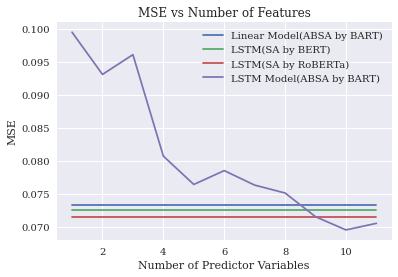

Model: ['usability_positive']
K = 10, Accuracy: 0.0870 +/- 0.0503

Model: ['usability_positive', 'design features_negative']
K = 10, Accuracy: 0.0915 +/- 0.0555

Model: ['usability_positive', 'design features_negative', 'general_neutral']
K = 10, Accuracy: 0.0999 +/- 0.0477

Model: ['usability_positive', 'design features_negative', 'general_neutral', 'price_positive']
K = 10, Accuracy: 0.0807 +/- 0.0483

Model: ['usability_positive', 'design features_negative', 'general_neutral', 'price_positive', 'quality_positive']
K = 10, Accuracy: 0.0764 +/- 0.0528

Model: ['usability_positive', 'design features_negative', 'general_neutral', 'price_positive', 'quality_positive', 'operation performance_negative']
K = 10, Accuracy: 0.0788 +/- 0.0467

Model: ['usability_positive', 'design features_negative', 'general_neutral', 'price_positive', 'quality_positive', 'operation performance_negative', 'operation performance_positive']
K = 10, Accuracy: 0.0763 +/- 0.0567

Model: ['usability_positive', 'des

In [131]:
# Visualize accuracy vs number of features
num_features = list(range(1, len(features)+1))
plt.plot(num_features, [0.0733 for i in range(len(num_features))], label='Linear Model(ABSA by BART)')
plt.plot(num_features, [0.0725 for i in range(len(num_features))], label='LSTM(SA by BERT)')
plt.plot(num_features, [0.0715 for i in range(len(num_features))], label='LSTM(SA by RoBERTa)')
plt.plot(num_features, accuracy_k10, label='LSTM Model(ABSA by BART)')
plt.xlabel('Number of Predictor Variables')
plt.ylabel('MSE')
plt.title('MSE vs Number of Features')
plt.legend()
plt.savefig("feature_importance_ABSA.jpg")
plt.show()

# Print the results
for model in models:
    print(f'Model: {model}')
    for k in k_values:
        accuracy_values = mse_dict[str(model)][k]
        mean_accuracy = np.mean(accuracy_values)
        std_accuracy = np.std(accuracy_values)
        print(f'K = {k}, Accuracy: {mean_accuracy:.4f} +/- {std_accuracy:.4f}')
        print()